In [ ]:
!pip install keybert

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.4 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.8.3-py3-none-any.whl size=39124 sha256=67b4ac3f1d850480ae932ea7ac42790d5358a063e8604f793c41e0e3a6ecc350
  Stored in directory: /root/.cache/pip/wheels/70/88/07/1a3bc11fd1dd5f89924a02dcbca89a3015e25e8faa31f904dc
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl 

In [ ]:
### import
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import pandas as pd
import re
import math
from multiprocessing import Pool
# nlp
from keybert import KeyBERT
from gensim.parsing.preprocessing import remove_stopwords
# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### data import
path="/content/drive/MyDrive/DS5500_Project Capstone/dataset/main_dataset.csv"
df = pd.read_csv(path)
df2 = pd.read_csv(path, dtype={'HS_Code': object})[:200]

In [ ]:
# df
df.shape

(42742, 2)

In [ ]:
# df2
df2.head()

,HS_Code,Description
0,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
1,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
2,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
3,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
4,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250


In [ ]:
### df preprocessing
# erase duplicates
df.drop_duplicates(inplace=True)
df.head()

,HS_Code,Description
0,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
8,500100,FREIGHT PREPAID CARGO IS STOWED IN A REFRIGERA...
23,500100,"705 CTN & 12,488 DZ PRS 2700 DZ PRS 70 COTTON ..."
25,500100,"OTHER, SUITABLE FOR FURNIT UREOTHER, SUITABLE ..."
26,500100,TUNNEL WARMER SUITABLE TUNNEL WARMER SUITABLE ...


In [ ]:
# preprocessing description df
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(lambda x: x.split('hs code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hscode')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('h s code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hs-code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hs.code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('h.s.code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('htscode')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts-code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts.code')[0])
df['Description'] = df['Description'].apply(lambda x: re.sub(r'\d{4}\.\d{2}','', x))
df['Description'] = df['Description'].apply(lambda x: re.sub(r'\d{6}|\d{10}','', x))
df['Description'] = df['Description'].str.replace('\W', ' ')

In [ ]:
# preprocessing description df2
df2['Description'] = df2['Description'].str.lower()
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hscode')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('h s code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs-code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('h.s.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('htscode')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts-code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: re.sub(r'\d{4}\.\d{2}','', x))
df2['Description'] = df2['Description'].apply(lambda x: re.sub(r'\d{6}|\d{10}','', x))
df2['Description'] = df2['Description'].str.replace('\W', ' ')

In [ ]:
### build model
# train test split
from sklearn.model_selection import train_test_split
df2.drop_duplicates(inplace=True)
df_train, df_val, y_train, y_val = train_test_split(df2, df2['HS_Code'], test_size=0.1)

# model
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [ ]:
# apply model
df['Keyword_with_Scores'] = df['Description'].apply(lambda x: kw_model.extract_keywords(x,keyphrase_ngram_range=(1, 3),
                                                                                        stop_words='english', use_maxsum=True,
                                                                                        nr_candidates=20, top_n=5))

In [ ]:
# delete null
delete_null=list(filter(lambda x : x is None, df["Keyword_with_Scores"]))
df=df.drop(df[df["Keyword_with_Scores"].apply(lambda x: x is None)].index)
df.shape

(377, 3)

In [ ]:
### extract function
# def
def extract_keywords(keyword_score_list):
    phrase_list = []
    if isinstance(keyword_score_list,(list,tuple)):
        for keyword in keyword_score_list:
            if keyword[1] > 0.5:
                phrase_list.append(keyword[0])
        phrase_non_unique = " ".join(phrase_list)
        unique_words = set(phrase_non_unique.split(' '))
        phrase = " ".join(unique_words)

        return phrase
    else:
        return ""

# apply
df['Keywords'] = df['Keyword_with_Scores'].apply(extract_keywords)

# show
df.head()

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 disconnectors suitable 362 s3cd,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma beef firbinogen,silk silk,500100
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",furnit ureother suitable,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cans cpm warmer suitable aluminum tunnel,silk silk,500100


In [ ]:
# lower
df['Keywords'] = np.where(df['Keyword_with_Scores'].str.len() == 0, df['Description'].str.lower(), df['Keywords'])
df.head()

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 disconnectors suitable 362 s3cd,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma beef firbinogen,silk silk,500100
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",furnit ureother suitable,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cans cpm warmer suitable aluminum tunnel,silk silk,500100


In [ ]:
df.shape

(377, 4)

In [ ]:
### import hscodedata
hs_path="/content/drive/MyDrive/DS5500_Project Capstone/dataset/HSCodeData.csv"
hs_df = pd.read_csv(hs_path, dtype={'id': object})
hs_df.head()

,Unnamed: 0,id,text,parent
0,0,010121,"Horses; live, pure",101
1,1,010129,"Horses; live, other than pure",101
2,2,010130,Asses; live,101
3,3,010190,Mules and hinnies; live,101
4,4,010221,"Cattle; live, pure",102


In [ ]:
# hs_df preprocessing
hs_df['text'] = hs_df['text'].str.replace('\W', ' ')
hs_df['text'] = hs_df['text'].str.lower()
hs_df['clean_text'] = hs_df['text'].apply(remove_stopwords)
hs_codes = df2.HS_Code.unique()

In [ ]:
# hs_df_trimmed
hs_df_trimmed = hs_df[hs_df['id'].isin(hs_codes)]
hs_df_trimmed.head()

,Unnamed: 0,id,text,parent,clean_text
2599,2599,500100,silk silk,5001,silk silk
2703,2703,520819,fabrics woven containing 85 or more by wei...,5208,fabrics woven containing 85 weight cotton unbl...
2704,2704,520821,fabrics woven containing 85 or more by wei...,5208,fabrics woven containing 85 weight cotton blea...
2705,2705,520822,fabrics woven containing 85 or more by wei...,5208,fabrics woven containing 85 weight cotton blea...
2706,2706,520823,fabrics woven containing 85 or more by wei...,5208,fabrics woven containing 85 weight cotton blea...


In [ ]:
### distance similarity
def jaccard_similarity(str1, str2):
    set1 = set(str1.split(' '))
    set2 = set(str2.split(' '))
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# use
import tensorflow as tf
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def us_encoder(str1, str2):
    set1 = set(str1.split(' '))
    set2 = set(str2.split(' '))

    # keyword_embedding = embed(set1)
    # clean_text_embeddings = embed(set2)
    embeddings = embed([str1, str2])
    similarity = np.inner(embeddings, embeddings)[0, 1]
    # similarities = np.inner(keyword_embedding, clean_text_embeddings)
    return similarity

In [ ]:
### test model
"""
df와 hs_df_trimmed의 [keywords] [clean_text]를 비교하여 가장 매칭이 높은
clean_text를 가져오고 해당 hs_code를 가져온다
"""
similarities=[]
best_matches = []
best_codes = []

for phrase in df['Keywords']:
    best_match = None
    best_similarity = 0
    best_code = None

    for sentence, hs_code in zip(hs_df_trimmed['clean_text'], hs_df_trimmed['id']):
        similarity = us_encoder(phrase, sentence)
        if similarity > best_similarity:
            best_similarity = similarity
            similarities.append(best_similarity)
            best_match = sentence
            best_code = hs_code

    best_matches.append(best_match)
    best_codes.append(best_code)

# Add the best matching sentences to df_phrases
df['BestMatch'] = best_matches
df['BestCode'] = best_codes
df.head()

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 disconnectors suitable 362 s3cd,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma beef firbinogen,silk silk,500100
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",furnit ureother suitable,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cans cpm warmer suitable aluminum tunnel,silk silk,500100


In [ ]:
df

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 disconnectors suitable 362 s3cd,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma beef firbinogen,silk silk,500100
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",furnit ureother suitable,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cans cpm warmer suitable aluminum tunnel,silk silk,500100
...,...,...,...,...,...,...
489,520842,plain weave weighing more than 100 g m2 0000,"[(plain, 0.3348), (weave weighing, 0.4142), (p...",weave weighing m2 100 0000,fabrics woven containing 85 weight cotton blea...,520822
491,520842,this credit no nbcm154 usfda registration no ...,"[(blanched marbled octopus, 0.398), (500 carto...",,silk silk,500100
495,520842,hts textile pcs goods,"[(hts, 0.5694), (goods, 0.6755), (pcs, 0.7149)...",textile hts goods pcs,silk silk,500100
497,520842,a taste of thai seasoning mixes 150 cartons ...,"[(jasmine rice 190, 0.4932), (mixes 150 carton...",curry 400 coconut spicy ginger cartons green t...,fabrics woven containing 85 weight cotton blea...,520823


In [ ]:
### accuracy function
def accuracy(y_true, y_pred):
    y_true_list=[]
    y_pred_list=[]
    correct_predictions = 0
    for yt, yp in zip(str(y_true), str(y_pred)):
        y_true_list.append(1)
        if yt == yp:
            y_pred_list.append(1)
            correct_predictions += 1
        else:
            y_pred_list.append(0)
    #returns accuracy
    return correct_predictions / len(y_true), y_true_list, y_pred_list

In [ ]:
# accuracy 함수 호출
result = accuracy(df['HS_Code'], df['BestCode'])

# 결과 출력
accuracy_score, y_true_list, y_pred_list = result
accuracy_score

0.376657824933687

Confusion Matrix:
[[ 4  0  1  0  1  0  0  0  0  0  0  0]
 [34  5  0  0  6  0  0  0  0  0  0  0]
 [ 8  1  2  0 17  0  0  0  0  0  0  0]
 [27  0  2  0  4  0  0  0  0  0  0  0]
 [ 7  2  1  2 10  0  0  0  0  0  0  0]
 [21  2  5  2  8  0  0  0  0  0  0  0]
 [ 3  1  8  0 33  0  0  0  0  0  0  0]
 [15  0  2  0 24  0  0  0  0  0  0  0]
 [24  4  1  2  7  0  0  0  0  0  0  0]
 [ 7  0  1  0 15  0  0  0  0  0  0  0]
 [ 3  3  3  0 25  0  0  0  0  0  0  0]
 [11  1  2  3  7  0  0  0  0  0  0  0]]


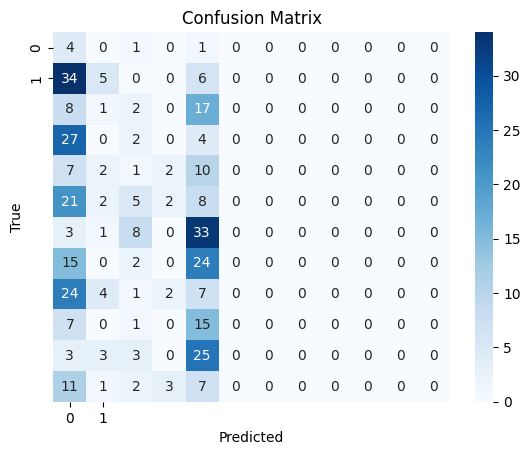

In [ ]:
df['HS_Code'] = df['HS_Code'].astype(int)
df['BestCode'] = df['BestCode'].astype(int)
# confusion_matrix_result = confusion_matrix(y_true_list, y_pred_list)
confusion_matrix_result = confusion_matrix(df['HS_Code'], df['BestCode'])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(confusion_matrix_result)
# 혼동 행렬 시각화
labels = [0, 1]  # 클래스 레이블
sns.heatmap(confusion_matrix_result, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df.loc[df['HS_Code'] == df['BestCode']]

In [ ]:
df.loc[df['HS_Code'] != df['BestCode']]

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 362 disconnectors suitable s3cd,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma firbinogen beef,silk silk,500100
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",suitable furnit ureother,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cpm cans aluminum warmer suitable tunnel,silk silk,500100
...,...,...,...,...,...,...
489,520842,plain weave weighing more than 100 g m2 0000,"[(plain, 0.3348), (weave weighing, 0.4142), (p...",100 weighing 0000 m2 weave,fabrics woven containing 85 weight cotton blea...,520822
491,520842,this credit no nbcm154 usfda registration no ...,"[(blanched marbled octopus, 0.398), (500 carto...",,silk silk,500100
495,520842,hts textile pcs goods,"[(hts, 0.5694), (goods, 0.6755), (pcs, 0.7149)...",hts textile pcs goods,silk silk,500100
497,520842,a taste of thai seasoning mixes 150 cartons ...,"[(jasmine rice 190, 0.4932), (mixes 150 carton...",cartons tangy green spicy 400 coconut curry gi...,fabrics woven containing 85 weight cotton blea...,520823


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
desc_sentence_embeddings = model.encode(df['Keywords'].tolist())
code_sentence_embeddings = model.encode(hs_df_trimmed['clean_text'].tolist())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

best_matches = []
best_codes = []

for phrase_embed in desc_sentence_embeddings:
    best_match = None
    best_similarity = 0
    best_code = None

    for sentence, hs_code, code_embed in zip(hs_df_trimmed['clean_text'], hs_df_trimmed['id'], code_sentence_embeddings):
        similarity = cosine_similarity([phrase_embed],[code_embed])[0]
        if similarity > best_similarity:
            best_similarity = similarity
            best_match = sentence
            best_code = hs_code

    best_matches.append(best_match)
    best_codes.append(best_code)

# Add the best matching sentences to df_phrases
df['BestMatch_ST'] = best_matches
df['BestCode_ST'] = best_codes

In [ ]:
df.head(10)

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode,BestMatch_ST,BestCode_ST
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",1250 362 disconnectors suitable s3cd,fabrics woven containing 85 weight cotton blea...,520823,fabrics woven containing 85 weight cotton blea...,520823
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma firbinogen beef,silk silk,500100,fabrics woven containing 85 weight cotton blea...,520822
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",,silk silk,500100,silk silk,500100
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",suitable furnit ureother,silk silk,500100,silk silk,500100
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",cpm cans aluminum warmer suitable tunnel,silk silk,500100,fabrics woven containing 85 weight cotton blea...,520821
30,500100,main reel reeling ehtf head and standard re,"[(ehtf, 0.5996), (standard, 0.6064), (reel ree...",ehtf standard reeling head main reel,fabrics woven containing 85 weight cotton blea...,520821,fabrics woven containing 85 weight cotton blea...,520823
44,520819,ikea home furnishing products tariff number 9...,"[(weight 10 total, 0.3904), (nsignment number ...",furnishing ikea products home,fabrics woven containing 85 weight cotton unbl...,520819,fabrics woven containing 85 weight cotton blea...,520823
45,520819,ikea home furnishing products tariff number 9...,"[(weight 10 total, 0.3945), (20533 sup ec, 0.4...",furnishing products home,fabrics woven containing 85 weight cotton unbl...,520819,silk silk,500100
46,520819,frozen swai fillets fda re gistration number ...,"[(gistration number 77894, 0.3334), (freight c...",fillets swai frozen,silk silk,500100,fabrics woven containing 85 weight cotton unbl...,520819
47,520819,frozen swai fillets fda re gistration number ...,"[(nw 42 000, 0.3746), (lbs 51 212, 0.3843), (l...",fda frozen gistration fillets swai,silk silk,500100,fabrics woven containing 85 weight cotton blea...,520821


In [ ]:
print(accuracy(df['HS_Code'], df['BestCode_ST'])*100)

5.488016672455713


In [ ]:
df['HS_Code_trim'] = df['HS_Code'].str[:-2]
df['BestCode_trim'] = df['BestCode'].str[:-2]
df['BestCode_ST_trim'] = df['BestCode_ST'].str[:-2]

In [ ]:
print(accuracy(df['HS_Code_trim'], df['BestCode_ST_trim'])*100)

20.18061827023272


In [ ]:
print(accuracy(df['HS_Code_trim'], df['BestCode_trim'])*100)

26.224383466481417


In [ ]:
df.head()

,HS_Code,Description,Keyword_with_Scores,Keywords,BestMatch,BestCode,BestMatch_ST,BestCode_ST,HS_Code_trim,BestCode_trim,BestCode_ST_trim
0,540792,woven fabric dyed,"[(fabric, 0.818), (dyed, 0.8403), (woven, 0.85...",dyed woven fabric,fabrics woven synthetic filament yarn dyed n e...,540792,fabrics woven synthetic filament yarn yarns di...,540793,5407,5407,5407
1,540792,dacron dyed woven fabric,"[(dacron, 0.5351), (fabric, 0.7264), (dyed, 0....",dyed woven dacron fabric,fabrics woven synthetic filament yarn dyed n e...,540792,fabrics woven synthetic filament yarn dyed n e...,540792,5407,5407,5407
2,540792,woven and dyed fabric,"[(dyed, 0.8317), (fabric, 0.8389), (woven, 0.8...",dyed woven fabric,fabrics woven synthetic filament yarn dyed n e...,540792,fabrics woven synthetic filament yarn yarns di...,540793,5407,5407,5407
3,540792,edip plain silken celestial 100 polyester ed...,"[(barley 35 viscose, 0.4776), (plain silken ar...",100 silken 35 celestial barley 211,None,None,yarn sewing thread single containing 85 weight...,550941,5407,None,5509
10,540792,furnishing fabrics commercial invoice no exgm...,"[(exgms, 0.3268), (commercial, 0.3842), (furni...",furnishing commercial 22 invoice exgms fabrics,fabrics woven viscose rayon high tenacity arti...,540810,yarn sewing thread multiple folded cabled yarn...,550922,5407,5408,5509
